# Contextual Multi-Arm Bandit
---

## Load Liblareis

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression

## Generate Sample Data

In [2]:
def generate_sample_data(sample_num=10000):
    weight = np.array([
        [0.05, 0.05, -0.05],
        [-0.05, 0.05, 0.05],
        [0.05, -0.05, 0.05],
    ])

    arm_num = weight.shape[0]
    feature_wight = weight

    feature_vector = np.random.rand(sample_num, feature_wight.shape[0])
    theta = np.dot(feature_vector, feature_wight)
    is_cv = (theta > np.random.rand(sample_num, arm_num)).astype(np.int8)

    return feature_vector, is_cv, weight

## Train Model

In [211]:
# %%debug
%load_ext autoreload
%autoreload
from contexual_bandit import ContextualBandit

# seed = 42
# np.random.seed(seed)

f_vector, rewords, weight = generate_sample_data(sample_num=10000)

n_arm = rewords.shape[1]
base_model = LogisticRegression(solver='lbfgs', random_state=seed)
bandit_model = ContextualBandit(base_model, n_arm, n_estimator=10)

batch_size = 100
lr_step = 500

random_rewords = []
predict_rewords = []

pred_arm_history = np.array([]).astype(int)
rand_arm_history = np.array([]).astype(int)

for i in tqdm(range(0, f_vector.shape[0], batch_size)):
    start = i
    end = start + batch_size
    # バッチデータの切り取り
    X_batch = f_vector[start:end]
    y_batch = rewords[start:end]
    
    
    # ランダム選択の挙動
    ## アームの選択
    ## 過去すべてのアーム選択リストに追加
    ## 報酬の計算
    random_chosen_arms = np.random.randint(n_arm, size=batch_size)
    rand_arm_history = np.append(rand_arm_history, random_chosen_arms)
    random_rewords.append( rewords[:end][np.arange(rand_arm_history.shape[0]), rand_arm_history].mean() )
    
    # ----------------------------------------------------------------------------------------------------------------
    
    # バンディットの挙動
    ## 初期処理
    ## アームを選ぶ（予測をする）
    ## 過去すべてのアーム選択リストに追加
    ## 報酬の計算
    ## 過去すべてのアーム選択リストを元に得られた報酬を取得し、モデルを再学習
    ### 再学習はバッチごとに行う。partial_fitも存在する
    
    if i == 0:
        # 初期処理
        chosen_arms = np.random.randint(n_arm, size=batch_size)
        pred_arm_history = np.append(pred_arm_history, chosen_arms)
        pred_arm_rewords = rewords[np.arange(chosen_arms.shape[0]), chosen_arms]
        bandit_model.fit(f_vector[:end], pred_arm_history, pred_arm_rewords)
    else:
        chosen_arms = bandit_model.predict(X_batch)
        pred_arm_history = np.append(pred_arm_history, chosen_arms)
        pred_arm_rewords = rewords[np.arange(pred_arm_history.shape[0]), pred_arm_history]
        
        if i % lr_step == batch_size:
            bandit_model.fit(f_vector[:end], pred_arm_history, pred_arm_rewords)
        else:
            # partial_fit を追記する。
            pass
    
    predict_rewords.append(rewords[:end][np.arange(pred_arm_history.shape[0]), pred_arm_history].mean())
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
from sklearn import metrics

armID = 2
model_armId = armID
label_armId = armID

for i in range(10):
    proba = bandit_model.estimators[model_armId, i].predict_proba(f_vector)[:, 1]
    print (proba[:5])
    fpr, tpr, thresholds = metrics.roc_curve(rewords[:, label_armId], proba)
    print ('{0}_estimator auc is {1}\n'.format(i, metrics.auc(fpr, tpr)))

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
0_estimator auc is 0.7004577397881389

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
1_estimator auc is 0.7004577397881389

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
2_estimator auc is 0.7004577397881389

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
3_estimator auc is 0.7004577397881389

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
4_estimator auc is 0.7004577397881389

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
5_estimator auc is 0.7004577397881389

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
6_estimator auc is 0.7004577397881389

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
7_estimator auc is 0.7004577397881389

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
8_estimator auc is 0.7004577397881389

[0.01783293 0.03677253 0.0087766  0.01721193 0.03802754]
9_estimator auc is 0.7004577397881389



[0.0, 0.025, 0.03, 0.0275, 0.028]
[0.03, 0.03, 0.02666666666666667, 0.0225, 0.028]


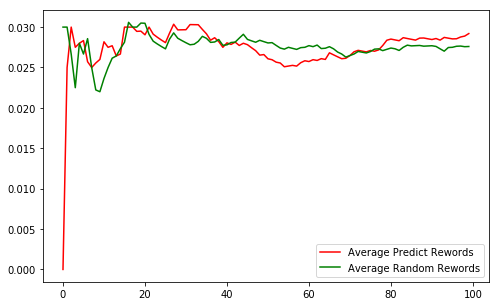

In [217]:
print (predict_rewords[:5])
print (random_rewords[:5])

plt.figure(figsize=(8, 5))
plt.plot(predict_rewords, color='r', label='Average Predict Rewords')
plt.plot(random_rewords, color='g', label='Average Random Rewords')
plt.legend()